<a href="https://colab.research.google.com/github/suchitsharma2004/Convolutional_Neural_Network/blob/main/ResNet50V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [ ]:
!pip install opendatasets
!pip install pandas
!pip install tensorflow

In [9]:
import opendatasets as od
import pandas


od.download("https://www.kaggle.com/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types")


100%|██████████| 2.02G/2.02G [01:11<00:00, 30.4MB/s]


In [ ]:
import cv2
import tensorflow as tf
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [28]:
train_path = 'lungs_4/Diseases/train'
test_path = 'lungs_4/Diseases/test'

In [29]:
class_names=os.listdir(train_path)
class_names_test=os.listdir(test_path)

In [30]:
print(class_names)
print(class_names_test)

['Viral Pneumonia', 'Corona Virus Disease', 'Normal', 'Bacterial Pneumonia', 'Tuberculosis']
['Viral Pneumonia', 'Corona Virus Disease', 'Normal', 'Bacterial Pneumonia', 'Tuberculosis']


In [31]:


train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('lungs_4/Diseases/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('lungs_4/Diseases/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 6054 images belonging to 5 classes.
Found 2025 images belonging to 5 classes.


In [32]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

In [33]:
IMAGE_SIZE = [224, 224]
from glob import glob

In [34]:
ress = ResNet50V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in ress.layers:
  layer.trainable = False



  # useful for getting number of classes
folders = glob('lungs_4/Diseases/train/*')

94668760/94668760 [==============================] - 3s 0us/step


In [35]:
x = Flatten()(ress.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=ress.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [36]:
from keras.callbacks import EarlyStopping
early=EarlyStopping(monitor='val_accuracy',min_delta=0, patience=20, verbose=1,mode='auto')

In [38]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set) , callbacks=[early]
)

<ipython-input-38-4f19659442a8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/20
190/190 [==============================] - 185s 975ms/step - loss: 3.5545 - accuracy: 0.7377 - val_loss: 3.9283 - val_accuracy: 0.7664
Epoch 2/20
190/190 [==============================] - 171s 901ms/step - loss: 2.9010 - accuracy: 0.8086 - val_loss: 3.5624 - val_accuracy: 0.7985
Epoch 3/20
190/190 [==============================] - 169s 889ms/step - loss: 2.5023 - accuracy: 0.8353 - val_loss: 2.8688 - val_accuracy: 0.8346
Epoch 4/20
190/190 [==============================] - 167s 881ms/step - loss: 2.4747 - accuracy: 0.8487 - val_loss: 3.4363 - val_accuracy: 0.8316
Epoch 5/20
190/190 [==============================] - 171s 902ms/step - loss: 2.3138 - accuracy: 0.8622 - val_loss: 3.5491 - val_accuracy: 0.8178
Epoch 6/20
190/190 [==============================] - 169s 890ms/step - loss: 2.1882 - accuracy: 0.8682 - val_loss: 4.6535 - val_accuracy: 0.7931
Epoch 7/20
190/190 [==============================] - 171s 901ms/step - loss: 2.2437 - accuracy: 0.8698 - val_loss: 4.8294 -

In [39]:
import matplotlib.pyplot  as plt

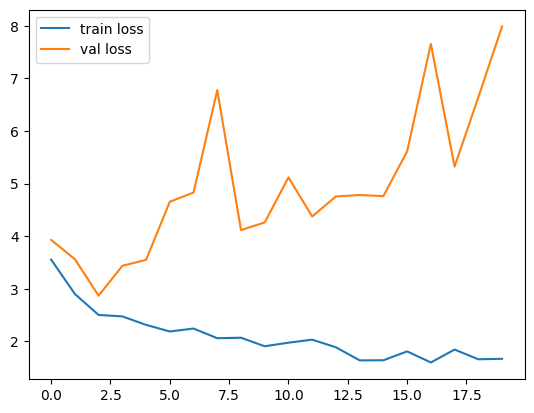

<Figure size 640x480 with 0 Axes>

In [40]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

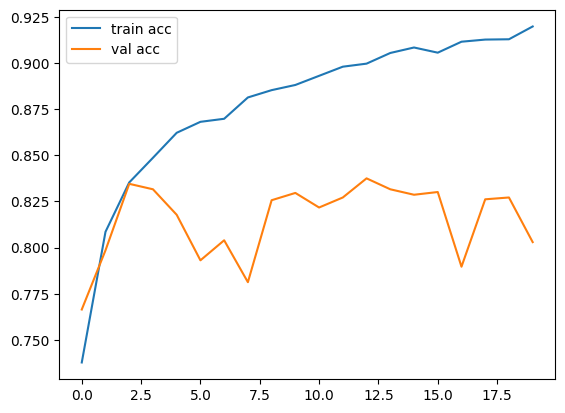

<Figure size 640x480 with 0 Axes>

In [41]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')